In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Redes Convolucionales

Para ver cómo se implementan estos tipos de redes, implementaremos un clasificador sobre el conjunto de entrenamiento de cuadrados y círculos del Tema 5

In [2]:
def circle(nx : int, ny: int, rad: int):
    '''funcion para construir circulos'''
    assert rad < min(nx,ny), 'el circulo debe estar completamente dentro'
    canvas = np.zeros(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            if ((i-nx//2)**2 + (j-ny//2)**2 < rad**2):
                canvas[i,j] = 1
    return np.float32(canvas)

def square(nx : int, ny: int, length: int):
    '''funcion para construir cuadradillos'''
    assert length < min(nx,ny)
    canvas = np.ones(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            if (np.abs(i-nx//2) > length) or (np.abs(j-ny//2) > length):
                canvas[i,j] = 0
    return np.float32(canvas)    

In [3]:
# creamos imágenes de 50x50 pixeles
nx = 50
ny = 50
rng = np.random.default_rng()
y_train = rng.integers(0,2,200)
x_train = []
for i in y_train:
    if i == 0:
        x_train.append(circle(nx, ny, rng.integers(1,25)))
    else:
        x_train.append(square(nx, ny, rng.integers(1,25)))

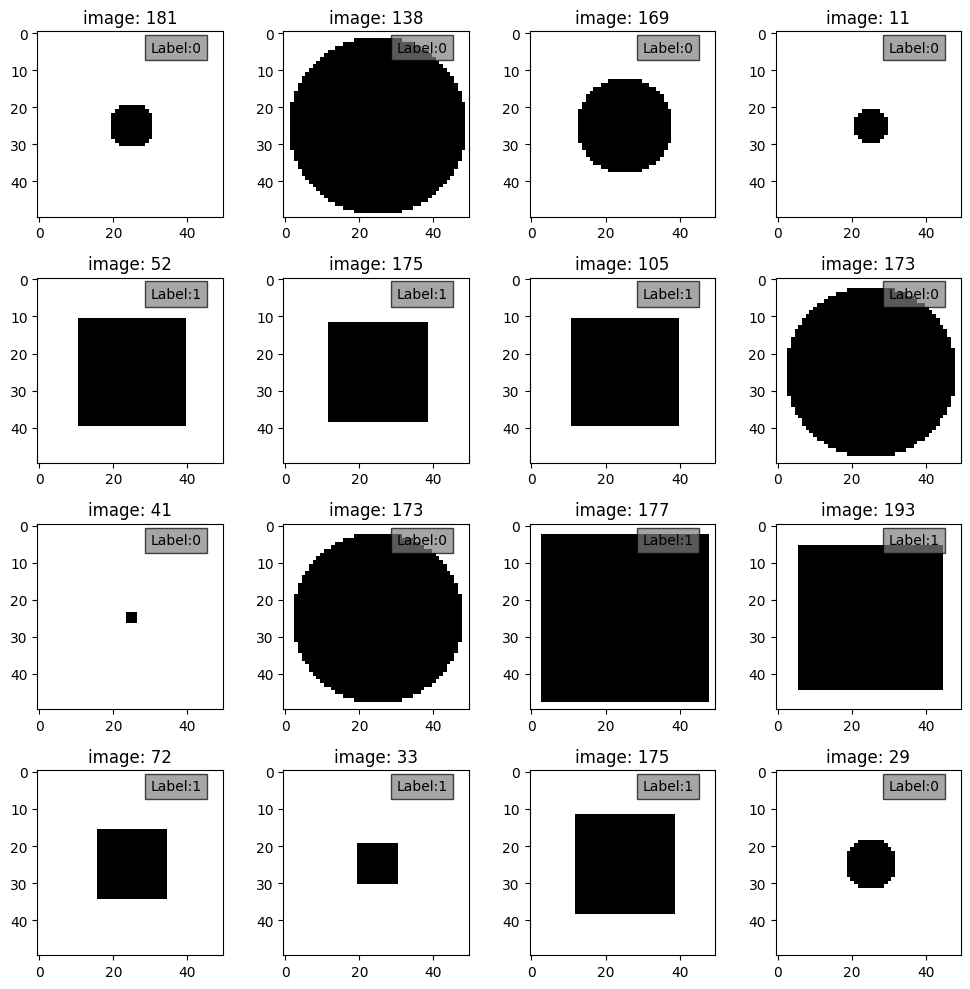

In [19]:
fig, axs = plt.subplots(4,4, figsize = (10,10))
for i in range(4):
    for j in range(4):
        idx = np.random.randint(0,200)
        axs[i,j].set_title(f'image: {idx}')
        axs[i,j].imshow(x_train[idx], cmap = 'binary')
        t = axs[i,j].text(30,5,f'Label:{y_train[idx]}')
        t.set_bbox({'facecolor' : 'gray', 'alpha': 0.7})
fig.tight_layout()

In [21]:
# Definimos un modelo
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=8,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)) 
        self.drop = torch.nn.Dropout(0.25)
        # 8, 50x50
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 8, 25x25
        self.conv2 = torch.nn.Conv2d(in_channels = 8, 
                                     out_channels=16, 
                                     kernel_size=3, 
                                     stride=1, 
                                     padding=1)
        # 16, 25x25
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(2)
        # 16, 12,12
        self.lin   = torch.nn.Linear(in_features = 16*12*12, 
                                     out_features = 2)
        self.sigm  = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(1)
        x = self.lin(x)
        x = self.sigm(x)
        return x

In [22]:
# creamos un modelo y chequeamos su funcionamiento
modelito = Model()
pred = modelito(torch.from_numpy(x_train[0]).view(1,1,50,50))
print(pred)

tensor([[0.5099, 0.4797]], grad_fn=<SigmoidBackward0>)


In [24]:
# Hacemos un ONE-HOT-ENCODING
labels = np.array([[1,0],[0,1]],dtype=np.float32)
y_train_1 = np.array([labels[0] if e == 0 else labels[1] for e in y_train])
print(np.array(x_train).shape, y_train_1.shape)

(200, 50, 50) (200, 2)


In [25]:
# convertimos nuestro training set en tensores de pytorch
x_train_1 = torch.from_numpy(np.array(x_train, dtype=np.float32)).view(200,1,50,50)
y_train_1 = torch.from_numpy(y_train_1)
print(x_train_1.shape, y_train_1.shape)

torch.Size([200, 1, 50, 50]) torch.Size([200, 2])


In [26]:
# Loss function y optimizador
criterio = torch.nn.MSELoss()
opt = torch.optim.Adam(modelito.parameters(), lr = 0.001)
hist = []

In [29]:
for e in range(100):
    ypred = modelito(x_train_1)
    loss = criterio(ypred, y_train_1)

    opt.zero_grad()
    loss.backward()
    opt.step()
    hist.append(loss.item())

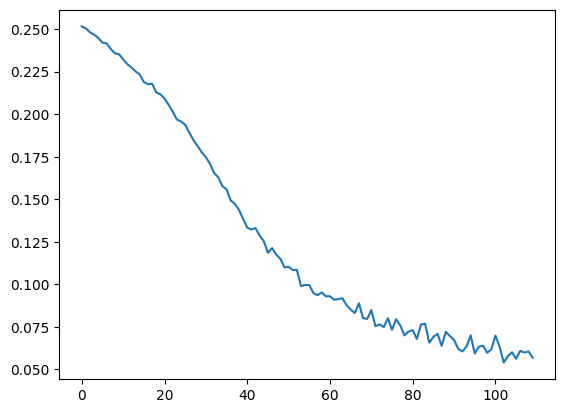

In [30]:
plt.plot(hist)

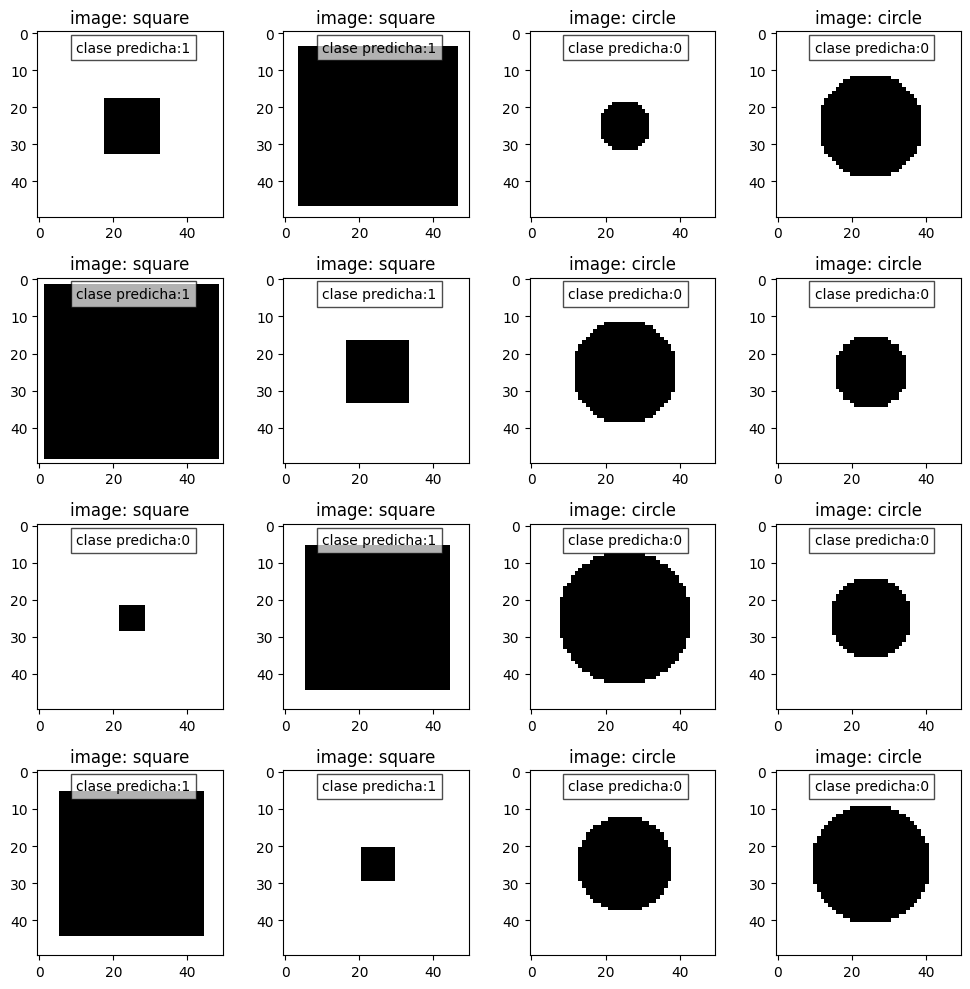

In [37]:
# Evaluamos el modelo en un grupo nuevo de imágenes
fig, axs = plt.subplots(4,4, figsize = (10,10))
for i in range(4):
    for j in range(4):
        if j < 2:  # squares
            test = square(nx, ny, rng.integers(3,25))
            pred = modelito(torch.from_numpy(test.reshape(1,1,50,50))).detach().numpy()
            axs[i,j].set_title(f'image: square')
            axs[i,j].imshow(test, cmap = 'binary')
            t = axs[i,j].text(10,5,f'clase predicha:{pred.argmax()}')
            t.set_bbox({'facecolor' : 'white', 'alpha': 0.7})
        else:
            test = circle(nx, ny, rng.integers(3,25))
            pred = modelito(torch.from_numpy(test.reshape(1,1,50,50))).detach().numpy()
            axs[i,j].set_title(f'image: circle')
            axs[i,j].imshow(test, cmap = 'binary')
            t = axs[i,j].text(10,5,f'clase predicha:{pred.argmax()}')
            t.set_bbox({'facecolor' : 'white', 'alpha': 0.7})
fig.tight_layout()



## Observando cómo actúan los filtros

Cuando se observan las imágenes filtradas al final de cada convolución (se tienen tantas como canales), se dice que se analizan los mapas de características o feature maps.

Veamos estas características para un par de ejemplos capa por capa

In [56]:
# Aplicando la primera convolucion
test_square = square(nx, ny, rng.integers(3,25))
ejemplo_square = modelito.conv1(torch.from_numpy(test_square.reshape(1,1,50,50))).detach().numpy()

test_circle = circle(nx, ny, rng.integers(3,25))
ejemplo_circle = modelito.conv1(torch.from_numpy(test_circle.reshape(1,1,50,50))).detach().numpy()
print(ejemplo.shape) # debe ser 8,50,50

(1, 8, 50, 50)


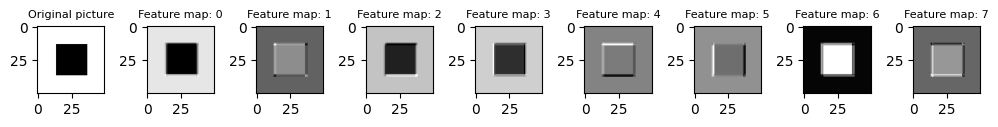

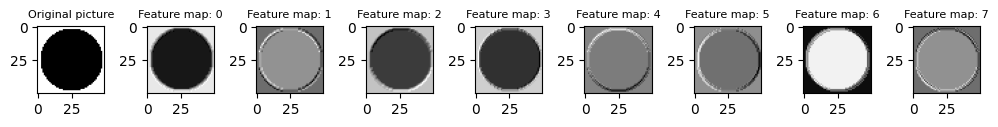

In [57]:
# veamos un cuadradito
fig, axs = plt.subplots(1,9, figsize = (10,3))
axs[0].set_title(f'Original picture', fontsize=8)
axs[0].imshow(test_square, cmap='binary')
for i in range(8):
    axs[i+1].set_title(f'Feature map: {i}', fontsize=8)
    axs[i+1].imshow(ejemplo_square[0,i,:], cmap='binary')
fig.tight_layout()

# veamos un circulito
fig, axs = plt.subplots(1,9, figsize = (10,3))
axs[0].set_title(f'Original picture', fontsize=8)
axs[0].imshow(test_circle, cmap='binary')
for i in range(8):
    axs[i+1].set_title(f'Feature map: {i}', fontsize=8)
    axs[i+1].imshow(ejemplo_circle[0,i,:], cmap='binary')
fig.tight_layout()

Para observar la segunda convolución, es importante aplicar todas las capas hasta llegar a ella (Sin implementar los dropouts)

In [58]:
# Segunda convolución

test_square = square(nx, ny, rng.integers(3,25))
x = modelito.conv1(torch.from_numpy(test_square.reshape(1,1,50,50)))
x = modelito.act1(x)
x = modelito.pool1(x)
ejemplo_square = modelito.conv2(x).detach().numpy()


test_circle = circle(nx, ny, rng.integers(3,25))
x = modelito.conv1(torch.from_numpy(test_circle.reshape(1,1,50,50)))
x = modelito.act1(x)
x = modelito.pool1(x)
ejemplo_circle = modelito.conv2(x).detach().numpy()

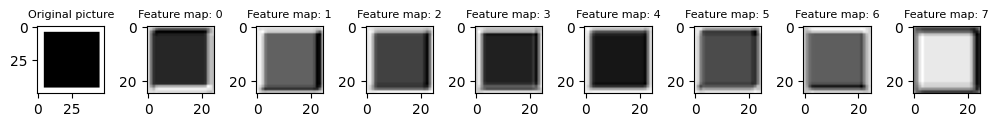

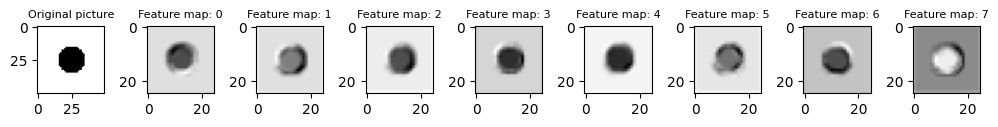

In [59]:
# veamos un cuadradito
fig, axs = plt.subplots(1,9, figsize = (10,3))
axs[0].set_title(f'Original picture', fontsize=8)
axs[0].imshow(test_square, cmap='binary')
for i in range(8):
    axs[i+1].set_title(f'Feature map: {i}', fontsize=8)
    axs[i+1].imshow(ejemplo_square[0,i,:], cmap='binary')
fig.tight_layout()

# veamos un circulito
fig, axs = plt.subplots(1,9, figsize = (10,3))
axs[0].set_title(f'Original picture', fontsize=8)
axs[0].imshow(test_circle, cmap='binary')
for i in range(8):
    axs[i+1].set_title(f'Feature map: {i}', fontsize=8)
    axs[i+1].imshow(ejemplo_circle[0,i,:], cmap='binary')
fig.tight_layout()

Como puede verse, no hay mucha magia. Los filtros demarcan círculos y cuadrados

## Explorando los filtros

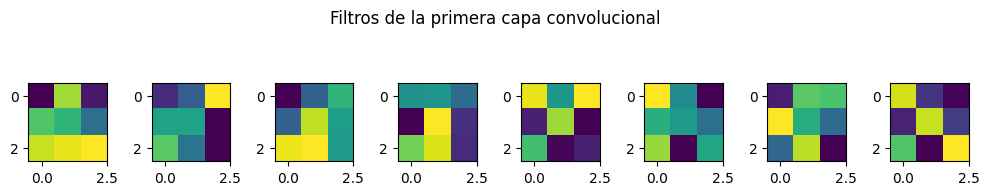

In [79]:
fig, axs = plt.subplots(1,8, figsize = (10,2))
i=0
fig.suptitle('Filtros de la primera capa convolucional')
for p in modelito.conv1.weight:
    axs[i].imshow(p.detach().numpy().reshape(3,3))
    i +=1
fig.tight_layout()

Para la segunda convolución, como el número de canales de entrada es 8 y el número de canales de salida es 16, tendremos 16 filtros por cada canal de entrada, es decir 8*16 filtros. 
Dibujaremos los correspondientes a los dos primeros canales

In [98]:
modelito.conv2.weight.shape

torch.Size([16, 8, 3, 3])

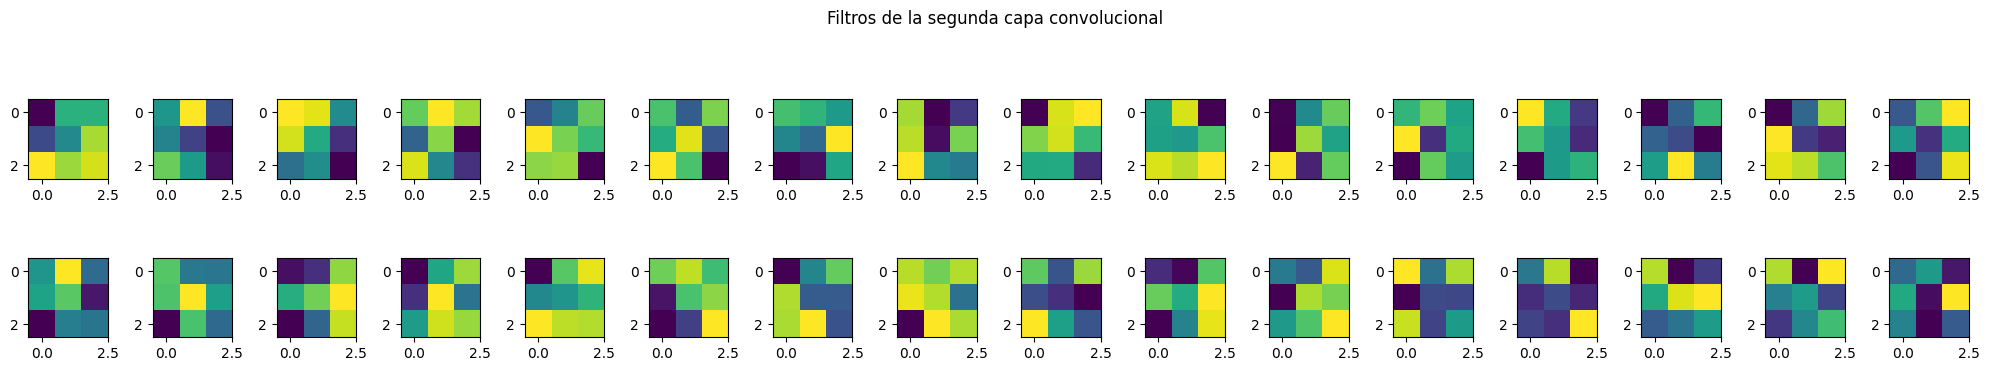

In [103]:
fig, axs = plt.subplots(2,16, figsize = (20,4))
i=0
j=0
fig.suptitle('Filtros de la segunda capa convolucional')
for i in range(16):
    for j in range(2):
        p = modelito.conv2.weight[i,j]
        axs[j,i].imshow(p.detach().numpy().reshape(3,3))
fig.tight_layout()